In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import git
import os
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import shift
from statannotations.Annotator import Annotator
import seaborn as sns

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Load frequently used methods
with open("notebooks/methods.py", "r") as file:
    exec(file.read())

# EMG and membrane potential correlation

## Correlation lag in one sample, one channel

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples.iloc[0]
sample

SID              W1_C1
AnimalID            W1
CellName            C1
Region          S1_L23
Date        2019 12 09
Depth       177.265396
Count              180
Location         W1/C1
Cortex              S1
Layer              L23
Name: 0, dtype: object

In [3]:
emg = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/emg/filter.pkl")
vm = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/vm/filter.pkl")

In [4]:
channel_i = 1
emg_data = emg.copy().pick(picks = [channel_i]).get_data()[ 0, : ]
vm_data = vm.copy().pick(picks = [channel_i]).get_data()[ 0, : ]
time = vm.times

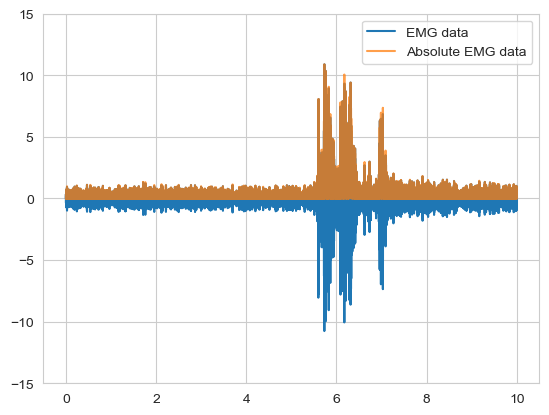

In [5]:
plt.plot(time, emg_data, label = "EMG data")
plt.plot(time, np.abs(emg_data), alpha = 0.75, label = "Absolute EMG data")
plt.ylim(-15, 15)
plt.legend()
plt.show()

Using the `filtfilt` method does not introduce time delays as described [here](https://se.mathworks.com/help/signal/ug/compensate-for-delay-and-distortion-introduced-by-filters.html).
The `sosfiltfilt` method should be preferred over the `filtfilt` method for most filtering tasks as specified in the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html).

In [6]:
butter_filter = signal.butter(
    N = 20,
    Wn = [ 100 ],
    btype = "lowpass",
    output = "sos",
    fs = 20_000
)

filtered = signal.sosfiltfilt(butter_filter, np.abs(emg_data))

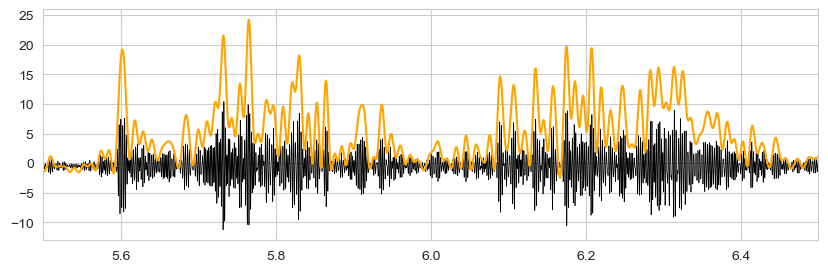

In [7]:
plt.figure(figsize = (10, 3))
plt.plot(time, (emg_data - np.mean(np.abs(emg_data))), linewidth = 0.5, c = "black")
plt.plot(time, (filtered - np.mean(filtered)) / 0.25, c = "orange")
plt.xlim(5.5, 6.5)
plt.show()

In [8]:
x = []
y = []

for lag in range(-5000, 5000, 50):
    x.append(lag / 20_000)
    y.append(pearsonr(vm_data, shift(filtered, lag)).statistic)

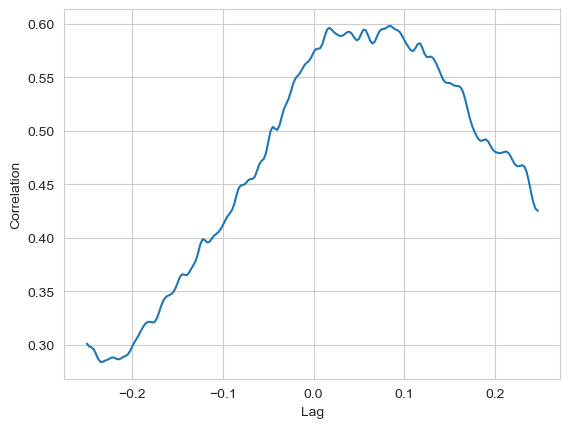

In [9]:
plt.plot(x, y)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

## Correlation lag in all samples from S1 L2/3

In [10]:
samples = pd.read_csv("sample_sheet.csv")
samples = samples[ samples["Region"] == "S1_L23" ]
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location,Cortex,Layer
0,W1_C1,W1,C1,S1_L23,2019 12 09,177.265396,180,W1/C1,S1,L23
1,W1_C2,W1,C2,S1_L23,2019 12 09,265.898093,270,W1/C2,S1,L23
2,W1_C8,W1,C8,S1_L23,2019 12 10,315.138481,320,W1/C8,S1,L23
3,W2_C3,W2,C3,S1_L23,2019 12 12,236.353861,240,W2/C3,S1,L23
4,W2_C4,W2,C4,S1_L23,2019 12 12,285.594248,290,W2/C4,S1,L23
5,W2_C5,W2,C5,S1_L23,2019 12 12,408.695218,415,W2/C5,S1,L23
6,W2_C6,W2,C6,S1_L23,2019 12 12,196.961551,200,W2/C6,S1,L23
7,W3_C10,W3,C10,S1_L23,2019 12 18,364.378869,370,W3/C10,S1,L23
8,W3_C11,W3,C11,S1_L23,2019 12 18,226.505783,230,W3/C11,S1,L23
9,W4_C10,W4,C10,S1_L23,2019 12 18,206.809628,210,W4/C10,S1,L23


In [11]:
lags = np.arange(-20_000, 20_000, 50) / 20_000

In [12]:
correlation_s1_l23 = []

for i, sample in samples.iterrows():    
    correlations = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv")
    correlation_s1_l23.append(np.mean(correlations, axis = 0))

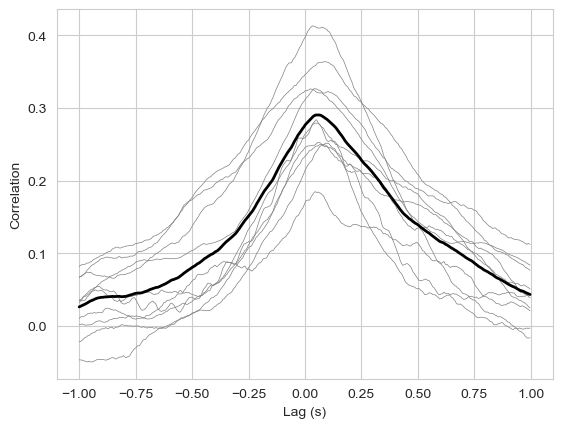

In [13]:
for correlation in correlation_s1_l23:
    plt.plot(lags, correlation, c = 'gray', linewidth = 0.5)

plt.plot(lags, np.mean(correlation_s1_l23, axis = 0), c = 'black', linewidth = 2)
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.show()

## Correlation lag in all samples from S1 L5

In [14]:
samples = pd.read_csv("sample_sheet.csv")
samples = samples[ samples["Region"] == "S1_L5" ]
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location,Cortex,Layer
10,W3_C12,W3,C12,S1_L5,2019 12 18,768.150047,780,W3/C12,S1,L5
11,W3_C13,W3,C13,S1_L5,2019 12 18,684.441388,695,W3/C13,S1,L5
12,W3_C14,W3,C14,S1_L5,2019 12 18,620.428884,630,W3/C14,S1,L5
13,W3_C15,W3,C15,S1_L5,2019 12 18,886.326978,900,W3/C15,S1,L5
14,W3_C16,W3,C16,S1_L5,2019 12 18,792.770241,805,W3/C16,S1,L5
15,W4_C11,W4,C11,S1_L5,2019 12 18,846.934668,860,W4/C11,S1,L5
16,W4_C12,W4,C12,S1_L5,2019 12 18,600.732729,610,W4/C12,S1,L5
17,W4_C13,W4,C13,S1_L5,2019 12 18,689.365427,700,W4/C13,S1,L5
18,W4_C14,W4,C14,S1_L5,2019 12 18,866.630823,880,W4/C14,S1,L5
19,W4_C15,W4,C15,S1_L5,2019 12 18,684.441388,695,W4/C15,S1,L5


In [15]:
correlation_s1_l5 = []

for i, sample in samples.iterrows():
    correlations = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv")
    correlation_s1_l5.append(np.mean(correlations, axis = 0))

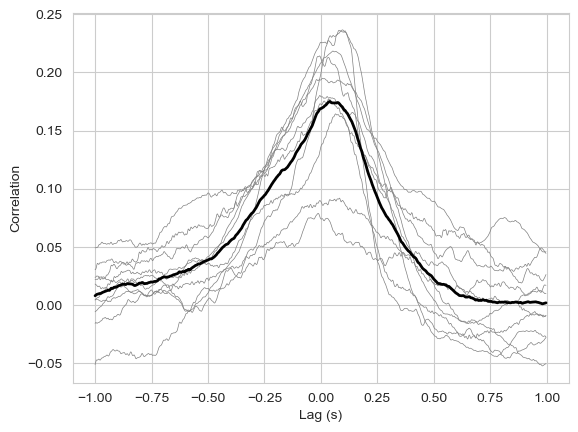

In [16]:
for correlation in correlation_s1_l5:
    plt.plot(lags, correlation, c = 'gray', linewidth = 0.5)

plt.plot(lags, np.mean(correlation_s1_l5, axis = 0), c = 'black', linewidth = 2)
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.show()

## Correlation lag in all samples from M1 L2/3

In [17]:
samples = pd.read_csv("sample_sheet.csv")
samples = samples[ samples["Region"] == "M1_L23" ]
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location,Cortex,Layer
20,W1_C3,W1,C3,M1_L23,2019 12 09,305.290403,310,W1/C3,M1,L23
21,W1_C4,W1,C4,M1_L23,2019 12 09,374.226946,380,W1/C4,M1,L23
22,W1_C5,W1,C5,M1_L23,2019 12 09,216.657706,220,W1/C5,M1,L23
23,W1_C6,W1,C6,M1_L23,2019 12 09,305.290403,310,W1/C6,M1,L23
24,W2_C1,W2,C1,M1_L23,2019 12 12,142.797124,145,W2/C1,M1,L23
25,W2_C2,W2,C2,M1_L23,2019 12 12,315.138481,320,W2/C2,M1,L23
26,W3_C1,W3,C1,M1_L23,2019 12 17,374.226946,380,W3/C1,M1,L23
27,W3_C2,W3,C2,M1_L23,2019 12 17,157.569240,160,W3/C2,M1,L23
28,W3_C3,W3,C3,M1_L23,2019 12 17,384.075024,390,W3/C3,M1,L23
29,W3_C7,W3,C7,M1_L23,2019 12 17,315.138481,320,W3/C7,M1,L23


In [18]:
correlation_m1_l23 = []

for i, sample in samples.iterrows():
    correlations = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv")
    correlation_m1_l23.append(np.mean(correlations, axis = 0))

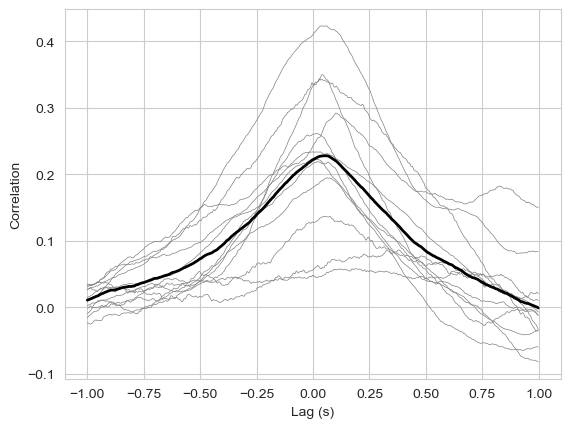

In [19]:
for correlation in correlation_m1_l23:
    plt.plot(lags, correlation, c = 'gray', linewidth = 0.5)

plt.plot(lags, np.mean(correlation_m1_l23, axis = 0), c = 'black', linewidth = 2)
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.show()

## Correlation lag in all samples from M1 L5

In [20]:
samples = pd.read_csv("sample_sheet.csv")
samples = samples[ samples["Region"] == "M1_L5" ]
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location,Cortex,Layer
32,W2_C7,W2,C7,M1_L5,2019 12 12,502.251954,510,W2/C7,M1,L5
33,W3_C4,W3,C4,M1_L5,2019 12 17,581.036574,590,W3/C4,M1,L5
34,W3_C5,W3,C5,M1_L5,2019 12 17,492.403877,500,W3/C5,M1,L5
35,W3_C6,W3,C6,M1_L5,2019 12 17,763.226009,775,W3/C6,M1,L5
36,W3_C8,W3,C8,M1_L5,2019 12 17,640.125039,650,W3/C8,M1,L5
37,W4_C3,W4,C3,M1_L5,2019 12 17,915.871210,930,W4/C3,M1,L5
38,W4_C4,W4,C4,M1_L5,2019 12 17,649.973117,660,W4/C4,M1,L5
39,W4_C5,W4,C5,M1_L5,2019 12 17,600.732729,610,W4/C5,M1,L5
40,W4_C7,W4,C7,M1_L5,2019 12 17,581.036574,590,W4/C7,M1,L5
41,W4_C8,W4,C8,M1_L5,2019 12 17,876.478900,890,W4/C8,M1,L5


In [21]:
correlation_m1_l5 = []

for i, sample in samples.iterrows():
    correlations = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv")
    correlation_m1_l5.append(np.mean(correlations, axis = 0))

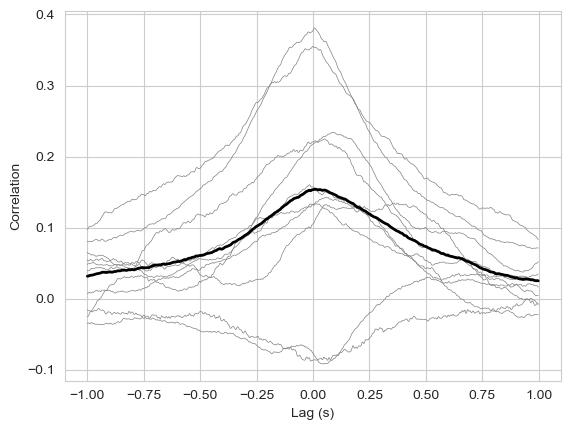

In [22]:
for correlation in correlation_m1_l5:
    plt.plot(lags, correlation, c = 'gray', linewidth = 0.5)

plt.plot(lags, np.mean(correlation_m1_l5, axis = 0), c = 'black', linewidth = 2)
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.show()

# Lagged correlation in different cortical areas

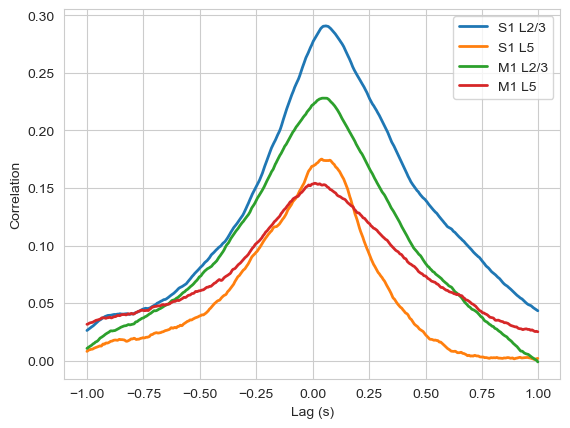

In [23]:
plt.plot(lags, np.mean(correlation_s1_l23, axis = 0), linewidth = 2, label = "S1 L2/3")
plt.plot(lags, np.mean(correlation_s1_l5, axis = 0), linewidth = 2, label = "S1 L5")
plt.plot(lags, np.mean(correlation_m1_l23, axis = 0), linewidth = 2, label = "M1 L2/3")
plt.plot(lags, np.mean(correlation_m1_l5, axis = 0), linewidth = 2, label = "M1 L5")
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.legend()
plt.show()

## When does the correlation peak?

In [24]:
samples = pd.read_csv("sample_sheet.csv")
lags = np.arange(-20_000, 20_000, 50) / 20_000

for i, sample in samples.iterrows():
    correlations = np.array(pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv"))
    time_max = lags[ np.argmax(np.abs(np.mean(correlations, axis = 0))) ]
    
    samples.loc[i, "MaxLagCorrelation"] = time_max

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1_L23 vs. S1_L5: Welch's t-test independent samples, P_val:3.047e-01 t=1.067e+00
S1_L5 vs. M1_L23: Welch's t-test independent samples, P_val:2.542e-01 t=-1.187e+00
M1_L23 vs. M1_L5: Welch's t-test independent samples, P_val:1.521e-01 t=1.516e+00
S1_L23 vs. M1_L23: Welch's t-test independent samples, P_val:4.612e-01 t=-7.612e-01
S1_L5 vs. M1_L5: Welch's t-test independent samples, P_val:5.682e-01 t=5.816e-01
S1_L23 vs. M1_L5: Welch's t-test independent samples, P_val:6.789e-02 t=1.968e+00


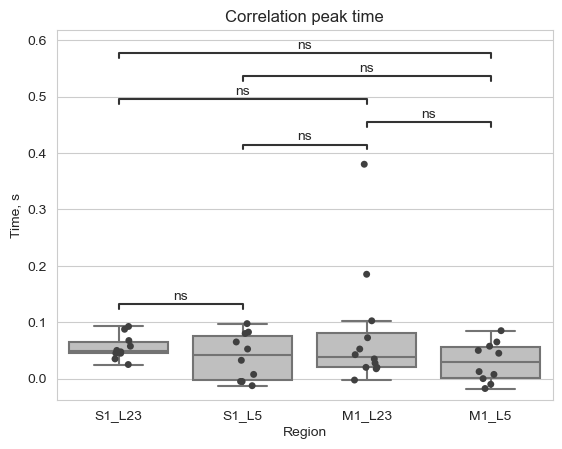

In [25]:
x = "Region"
y = "MaxLagCorrelation"
order = pd.unique(samples["Region"])

pairs = [
    ("S1_L23", "S1_L5"),
    ("S1_L23", "M1_L23"),
    ("S1_L23", "M1_L5"),
    ("S1_L5", "M1_L23"),
    ("S1_L5", "M1_L5"),
    ("M1_L23", "M1_L5")
]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, color = ".25", order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Correlation peak time")
plt.ylabel("Time, s")
plt.show()

### Correlation peak in L2/3 and L5

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L23 vs. L5: Welch's t-test independent samples, P_val:8.424e-02 t=1.785e+00


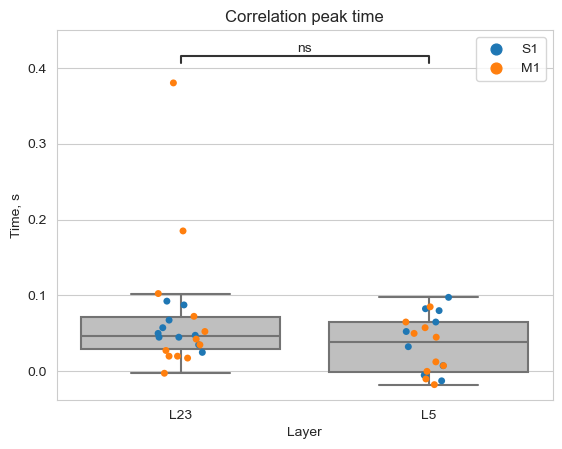

In [26]:
x = "Layer"
y = "MaxLagCorrelation"
color = "Cortex"
order = pd.unique(samples["Layer"])

pairs = [("L23", "L5")]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, hue = color, order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Correlation peak time")
plt.ylabel("Time, s")
plt.legend(loc = "upper right")
plt.show()

### Correlation peak time in S1 and M1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1 vs. M1: Welch's t-test independent samples, P_val:6.369e-01 t=-4.772e-01


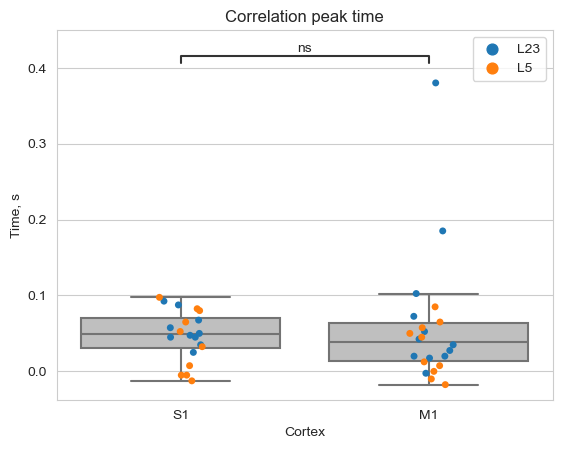

In [27]:
x = "Cortex"
y = "MaxLagCorrelation"
color = "Layer"
order = pd.unique(samples["Cortex"])

pairs = [("S1", "M1")]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, hue = color, order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Correlation peak time")
plt.ylabel("Time, s")
plt.legend(loc = "upper right")
plt.show()

## Is correlation different on time point 0?

In [28]:
samples = pd.read_csv("sample_sheet.csv")
lags = np.arange(-20_000, 20_000, 50) / 20_000

for i, sample in samples.iterrows():
    correlations = np.array(pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv"))
    time_point = np.argwhere(lags == 0)
    corr = np.abs(np.mean(correlations, axis = 0))[ time_point ][0]

    samples.loc[i, "Correlation0"] = corr

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1_L23 vs. S1_L5: Welch's t-test independent samples, P_val:1.011e-03 t=3.963e+00
S1_L5 vs. M1_L23: Welch's t-test independent samples, P_val:1.537e-01 t=-1.496e+00
M1_L23 vs. M1_L5: Welch's t-test independent samples, P_val:4.441e-01 t=7.813e-01
S1_L23 vs. M1_L23: Welch's t-test independent samples, P_val:1.708e-01 t=1.425e+00
S1_L5 vs. M1_L5: Welch's t-test independent samples, P_val:6.556e-01 t=-4.563e-01
S1_L23 vs. M1_L5: Welch's t-test independent samples, P_val:3.898e-02 t=2.258e+00


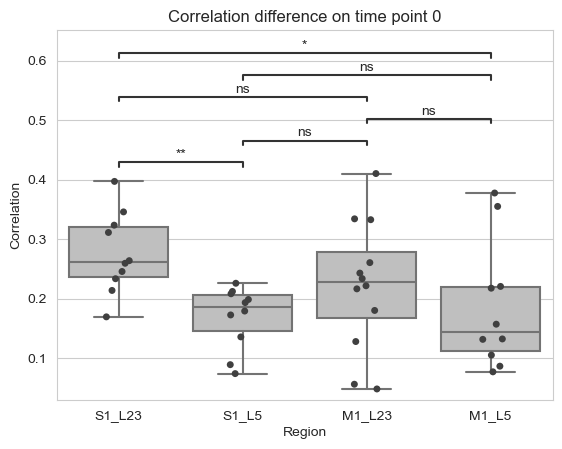

In [29]:
x = "Region"
y = "Correlation0"
order = pd.unique(samples["Region"])

pairs = [
    ("S1_L23", "S1_L5"),
    ("S1_L23", "M1_L23"),
    ("S1_L23", "M1_L5"),
    ("S1_L5", "M1_L23"),
    ("S1_L5", "M1_L5"),
    ("M1_L23", "M1_L5")
]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, color = ".25", order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Correlation difference on time point 0")
plt.ylabel("Correlation")
plt.show()

### Correlation difference on time point 0 in L2/3 and L5

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L23 vs. L5: Welch's t-test independent samples, P_val:1.520e-02 t=2.537e+00


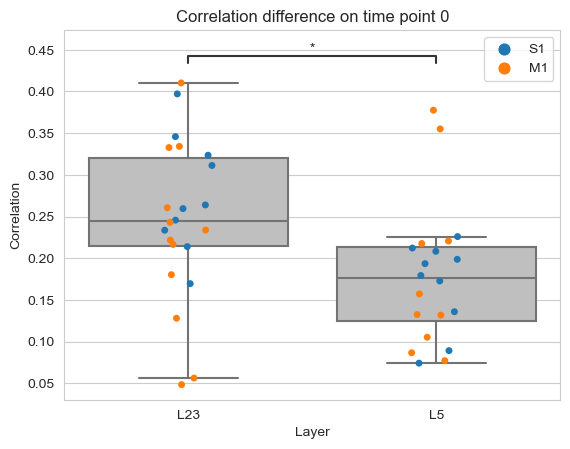

In [30]:
x = "Layer"
y = "Correlation0"
color = "Cortex"
order = pd.unique(samples["Layer"])

pairs = [("L23", "L5")]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, hue = color, order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Correlation difference on time point 0")
plt.ylabel("Correlation")
plt.legend(loc = "upper right")
plt.show()

### Correlation difference on time point 0 in S1 and M1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1 vs. M1: Welch's t-test independent samples, P_val:5.644e-01 t=5.813e-01


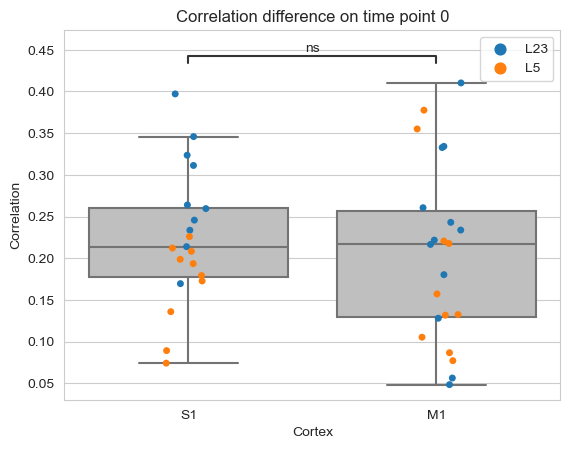

In [31]:
x = "Cortex"
y = "Correlation0"
color = "Layer"
order = pd.unique(samples["Cortex"])

pairs = [("S1", "M1")]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, hue = color, order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Correlation difference on time point 0")
plt.ylabel("Correlation")
plt.legend(loc = "upper right")
plt.show()

## Is maximum correlation different?

In [32]:
samples = pd.read_csv("sample_sheet.csv")

for i, sample in samples.iterrows():
    correlations = np.array(pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/lagged_correlation.csv"))
    corr = np.max(np.abs(np.mean(correlations, axis = 0)))

    samples.loc[i, "MaxCorrelation"] = corr

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1_L23 vs. S1_L5: Welch's t-test independent samples, P_val:5.724e-04 t=4.198e+00
S1_L5 vs. M1_L23: Welch's t-test independent samples, P_val:1.379e-01 t=-1.558e+00
M1_L23 vs. M1_L5: Welch's t-test independent samples, P_val:3.786e-01 t=9.008e-01
S1_L23 vs. M1_L23: Welch's t-test independent samples, P_val:1.397e-01 t=1.544e+00
S1_L5 vs. M1_L5: Welch's t-test independent samples, P_val:6.907e-01 t=-4.065e-01
S1_L23 vs. M1_L5: Welch's t-test independent samples, P_val:2.195e-02 t=2.551e+00


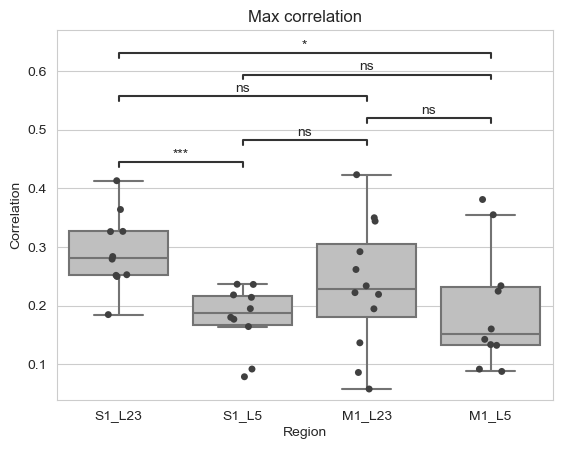

In [33]:
x = "Region"
y = "MaxCorrelation"
order = pd.unique(samples["Region"])

pairs = [
    ("S1_L23", "S1_L5"),
    ("S1_L23", "M1_L23"),
    ("S1_L23", "M1_L5"),
    ("S1_L5", "M1_L23"),
    ("S1_L5", "M1_L5"),
    ("M1_L23", "M1_L5")
]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, color = ".25", order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Max correlation")
plt.ylabel("Correlation")
plt.show()

### Max correlation difference in L2/3 and L5

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L23 vs. L5: Welch's t-test independent samples, P_val:8.692e-03 t=2.760e+00


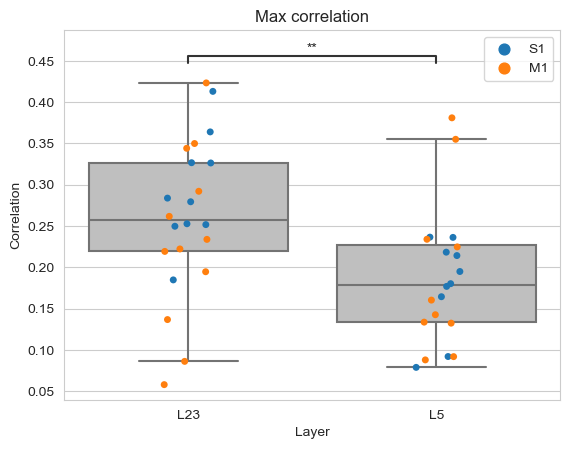

In [34]:
x = "Layer"
y = "MaxCorrelation"
color = "Cortex"
order = pd.unique(samples["Layer"])

pairs = [("L23", "L5")]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, hue = color, order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Max correlation")
plt.ylabel("Correlation")
plt.legend(loc = "upper right")
plt.show()

### Max correlation difference in S1 and M1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1 vs. M1: Welch's t-test independent samples, P_val:5.057e-01 t=6.718e-01


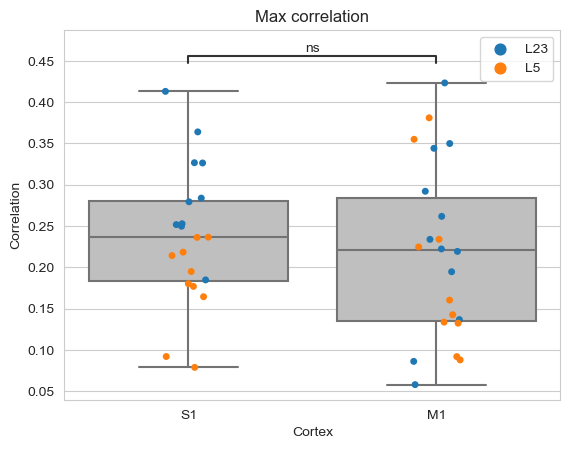

In [35]:
x = "Cortex"
y = "MaxCorrelation"
color = "Layer"
order = pd.unique(samples["Cortex"])

pairs = [("S1", "M1")]

ax = sns.boxplot(x = x, y = y, data = samples, showfliers = False, color = ".75", order = order)
sns.stripplot(x = x, y = y, data = samples, hue = color, order = order)

annotator = Annotator(
    ax,
    data = samples,
    x = x,
    y = y,
    order = order,
    pairs = pairs
)
annotator.configure(test = "t-test_welch", text_format = "star", loc = "inside")
annotator.apply_and_annotate()

plt.title("Max correlation")
plt.ylabel("Correlation")
plt.legend(loc = "upper right")
plt.show()